Copied from 2017-08-30

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from matplotlib import cm
import pandas as pd
import os
import json
import subprocess
import cv2
import glob
%matplotlib inline

In [3]:
from opmap.VideoData import VideoData
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.util import makeMovie
from opmap.cmap import bipolar

In [82]:
dict_ = {
    'category' : ["1.0_meandering","1.22_meandering","1.22_pivoting","1.4_pivoting"],
    'session' : ["20170809-4","20170823-5","20170823-5","20170829-2"],
    'size_W' : [300, 400, 400, 300], 
    'size_H' : [300, 200, 200, 150], 
    'off_x' : [160, 120,200,240],
    'off_y' : [115,0,75,55],
    'size_w' : [40,60,60,40],
    'size_h' : [40,60,60,40],
    'f_start' : [180, 300,700,190],
    'f_end' : [260,400,800,270],
    'pnt_x0' : [20,20,20,10],
    'pnt_y0' : [8, 8, 8, 16],
    'pnt_n' : [5,5,5,5],
    'step_x' : [0,0,0,0],
    'step_y' : [2,2,2,2],    
}

df = pd.DataFrame(dict_)
df

,category,f_end,f_start,off_x,off_y,pnt_n,pnt_x0,pnt_y0,session,size_H,size_W,size_h,size_w,step_x,step_y
0,1.0_meandering,260,180,160,115,5,20,8,20170809-4,300,300,40,40,0,2
1,1.22_meandering,400,300,120,0,5,20,8,20170823-5,200,400,60,60,0,2
2,1.22_pivoting,800,700,200,75,5,20,8,20170823-5,200,400,60,60,0,2
3,1.4_pivoting,270,190,240,55,5,10,16,20170829-2,150,300,40,40,0,2


In [78]:
wf_width = 1

sim_dir_root =    '/mnt/recordings/SimulationResults/'
save_dir_root = '/mnt/recordings/AnalysisResult/Tomii/2017-09-01/'

if not os.path.exists(save_dir_root) : os.makedirs(save_dir_root)
df.to_csv(os.path.join(save_dir_root, 'data.csv'))


In [62]:
def plot_phasewire(X,Y,Z,ax):
    
    wire = ax.plot_wireframe(X, Y, Z)
    ax.set_zlim([-np.pi, np.pi])
        
    # Retrive data from internal storage of plot_wireframe, then delete it
    nx, ny, _  = np.shape(wire._segments3d)
    wire_x = np.array(wire._segments3d)[:, :, 0].ravel()
    wire_y = np.array(wire._segments3d)[:, :, 1].ravel()
    wire_z = np.array(wire._segments3d)[:, :, 2].ravel()
    wire.remove()

    # create data for a LineCollection
    wire_x1 = np.vstack([wire_x, np.roll(wire_x, 1)])
    wire_y1 = np.vstack([wire_y, np.roll(wire_y, 1)])
    wire_z1 = np.vstack([wire_z, np.roll(wire_z, 1)])
    to_delete = np.arange(0, nx*ny, ny)
    wire_x1 = np.delete(wire_x1, to_delete, axis=1)
    wire_y1 = np.delete(wire_y1, to_delete, axis=1)
    wire_z1 = np.delete(wire_z1, to_delete, axis=1)
    scalars = np.delete(wire_z, to_delete)

    segs = [list(zip(xl, yl, zl)) for xl, yl, zl in \
                 zip(wire_x1.T, wire_y1.T, wire_z1.T)]

    my_wire = art3d.Line3DCollection(segs, cmap="hsv")
    my_wire.set_array(scalars)
    ax.add_collection(my_wire)

    plt.colorbar(my_wire)
    

/mnt/recordings/AnalysisResult/Tomii/2017-09-01/20170809-4/1.0_meandering
180 123
180 125
180 127
180 129
180 131


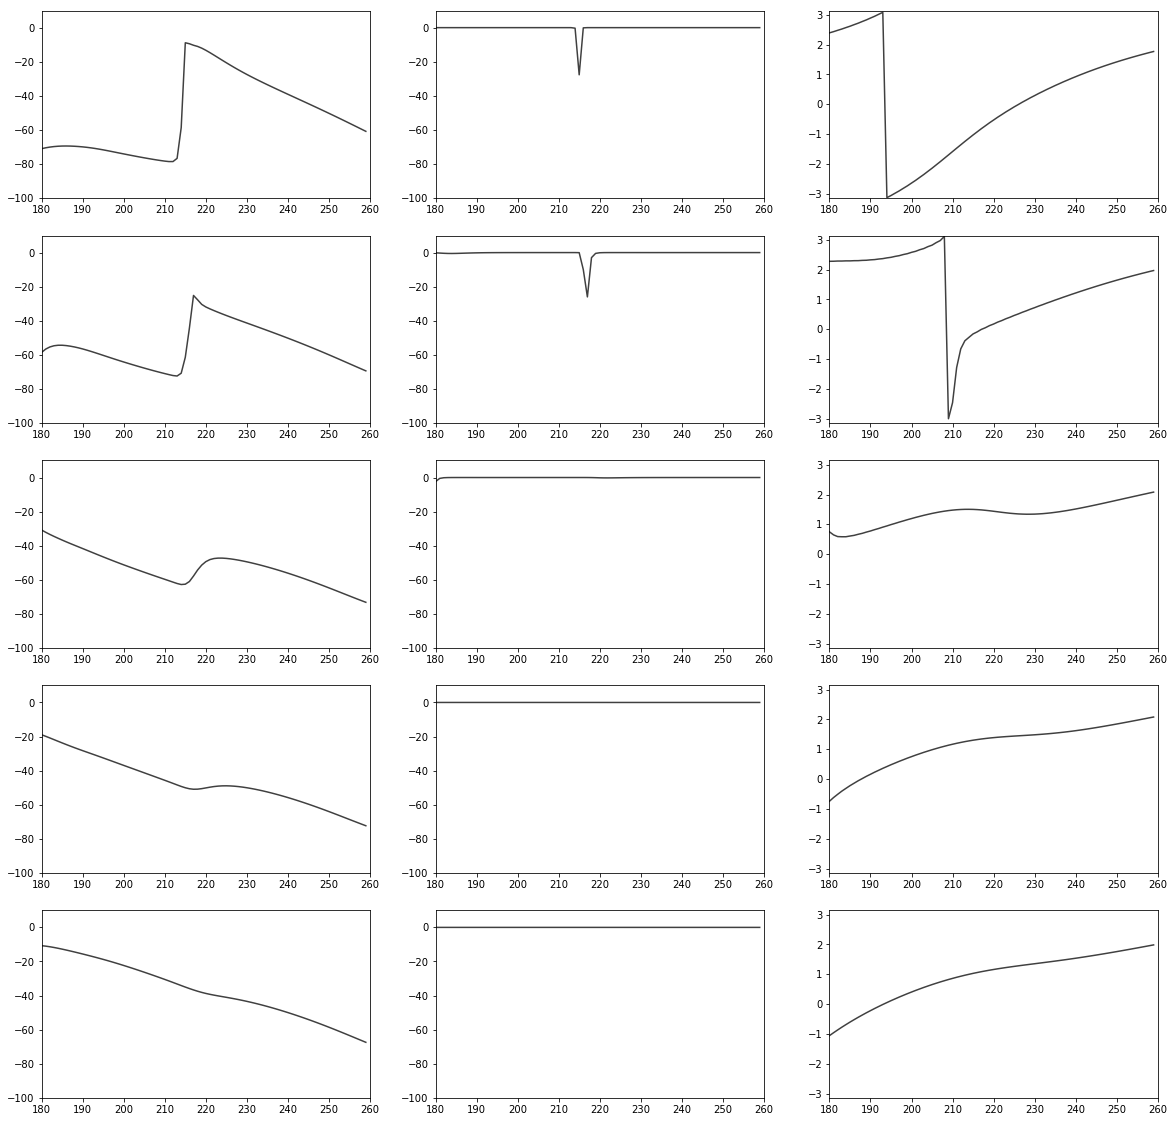

/mnt/recordings/AnalysisResult/Tomii/2017-09-01/20170829-2/1.4_pivoting
250 71
250 73
250 75
250 77
250 79


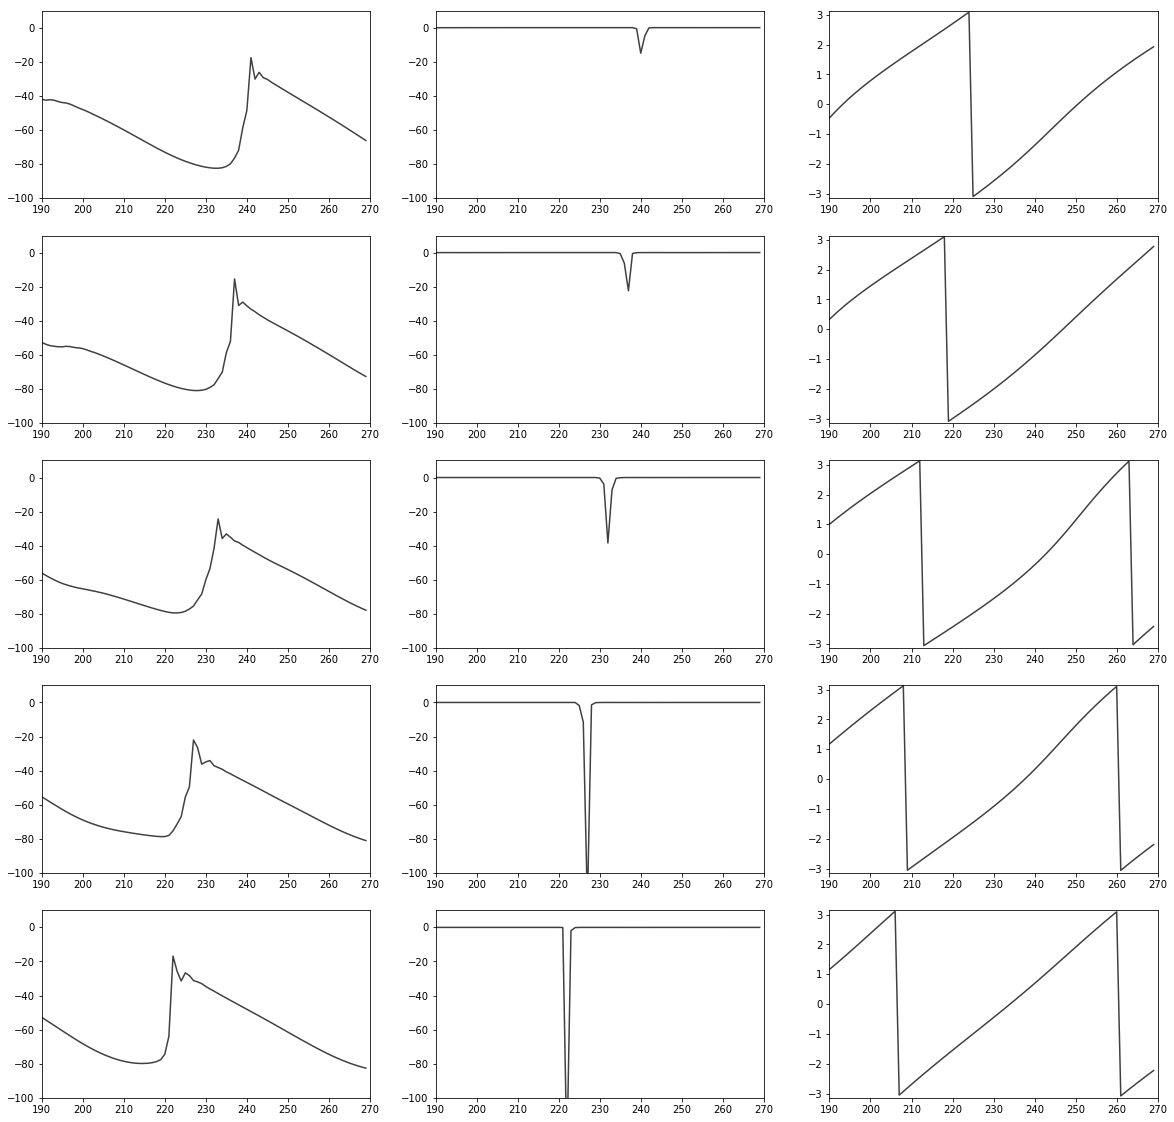

In [85]:
#sessions = np.arange(4)
sessions=[0,3]
for i in sessions:
    
    s = df.loc[i,:]
    size_H = s['size_H']
    size_W = s['size_W']
    size_h = s['size_h']
    size_w = s['size_w']
    f_start = s['f_start']
    f_end = s['f_end']
    off_x = s['off_x']
    off_y = s['off_y']
    
    data_dir = os.path.join(sim_dir_root, s['session'])
    save_dir = data_dir.replace( sim_dir_root, save_dir_root)
    save_dir = os.path.join(save_dir, s['category'])
    print save_dir    
    
    if not os.path.exists(save_dir): os.makedirs(save_dir)
    vmem_files = glob.glob(data_dir+ '/vmem*.npy')
    length = len( vmem_files )
    
    vm_array = np.zeros((length, size_H,size_W)) 
    hj_array = np.zeros((length, size_H,size_W))
    Ina = np.zeros((length, size_H,size_W))
    
    for j, f in enumerate(sorted(vmem_files)):
        vm_array[j, :, :] = np.load( f )
        cell_dir = f.replace('vmem_', 'cell_').replace('.npy', '')
        if not os.path.exists(cell_dir) : continue
        a = np.load(  os.path.join( cell_dir,  'h.npy') )
        b = np.load(  os.path.join( cell_dir,  'j.npy') )
        hj_array[j, :, :] = a*b
        Ina[j, :, :] = np.load( os.path.join( cell_dir, 'xina.npy') )

    vmem = VideoData(length, size_H,size_W)
    vmem.data = np.copy(vm_array)
    vmem.cmap = bipolar(neutral=0, lutsize=1024)
    vmem.vmin = np.min(vmem.data)
    vmem.vmax = np.max(vmem.data)
    pmap = PhaseMap(vmem, shrink=1)
    pvmap = PhaseVarianceMap(pmap, size=3)
        
    #vmem.saveImage(os.path.join(save_dir, 'vmem'))
    #pmap.saveImage(os.path.join(save_dir, 'pmap'))

    if False:
        
        dirs = {}
        keys = [
            'surface_top', 
            'surface_bottom', 
            'plot',
            'zoom_row',
            'zoom_pair'
        ]
        for key in keys:
            d = os.path.join(save_dir, key)
            dirs[key] = d
            if not os.path.exists(d): os.makedirs(d)

        y = np.arange(size_h)
        x = np.arange(size_w)
        X, Y = np.meshgrid(x, y)    

        vmem_min = np.min(vmem.data)
        vmem_max=np.max(vmem.data)

        for f in range(f_start, f_end):
            plt.close("all")
            Z =np.copy( pmap.data[f-3,off_y:off_y+size_h,off_x:off_x+size_w] )

            if True:
                fig = plt.figure(figsize=(15,5))

                plt.subplot(1,4,1)
                plt.imshow(
                    vmem.data[f,off_y:off_y+size_h,off_x:off_x+size_w],
                    cmap=bipolar(neutral=0, lutsize=1024), vmin=vmem_min, vmax=vmem_max,
                    interpolation='nearest'
                )

                plt.subplot(1,4,2)
                im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8) 
                im_out[:, :, 1] = (np.sum((Ina[f-wf_width:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
                im_out[:, :, 2] = (np.sum((Ina[f-wf_width:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
                im_out = 255 - im_out
                plt.imshow(im_out)
                v = plt.axis()
                HJ = hj_array[f,off_y:off_y+size_h,off_x:off_x+size_w]
                plt.contour(X, Y, HJ)
                plt.axis(v)

                plt.subplot(1,4,3)
                plt.imshow(
                    Z, 
                    cmap='gray', vmin=-np.pi, vmax=np.pi,
                    interpolation='nearest'
                )

                plt.subplot(1,4,4)
                plt.imshow(
                    pvmap.data[f-3,off_y:off_y+size_h,off_x:off_x+size_w],
                    cmap='gray', vmin=0, vmax=1,
                    interpolation='nearest'
                )

                plt.savefig(
                    os.path.join(dirs['zoom_row'], "{0:0>4}.png".format(f)),
                    bbox_inches='tight'
                )

            if True:
                fig = plt.figure(figsize=(8,5))
                #fig = plt.figure()

                #plt.subplot(1,3,1)
                #pmap.showFrame(f)

                plt.subplot(1,2,1)
                im_out = np.zeros([size_h, size_w, 3], dtype=np.uint8) 
                im_out[:, :, 1] = (np.sum((Ina[f-1:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
                im_out[:, :, 2] = (np.sum((Ina[f-1:f, off_y:off_y+size_h,off_x:off_x+size_w] < -1), axis=0) > 0) * 255
                im_out = 255 - im_out
                plt.imshow(im_out)
                v = plt.axis()
                HJ = hj_array[f,off_y:off_y+size_h,off_x:off_x+size_w]
                plt.contour(X, Y, HJ)
                plt.axis(v)

                plt.subplot(1,2,2)
                #Z[:20, :] = Z[20, :]
                plt.imshow(
                    Z, 
                    cmap='gray', vmin=-np.pi, vmax=np.pi,
                    interpolation='nearest'
                )

                plt.savefig(
                    os.path.join(dirs['zoom_pair'], "{0:0>4}.png".format(f)),
                    bbox_inches='tight'
                )

            if True:
                fig = plt.figure(figsize=(10,5))
                markers = 'osxD^v+<>p'
                for i, pos_x in enumerate(np.arange(10, size_w, 10)): 
                #for pos_x in np.array([40, 50]): 
                    plt.plot(
                        Z[:,pos_x], 
                        label='{0}'.format(pos_x),
                        marker=markers[i],
                        color = '192',
                        #antialiased=False
                    )
                plt.ylim([-np.pi, np.pi])
                plt.xlim([0, size_h-1])
                plt.legend()
                #plt.gca().set_aspect('equal')    
                #plt.show()

                plt.savefig(
                    os.path.join(dirs['plot'], "{0:0>4}.png".format(f)),
                    bbox_inches='tight'
                )

            if True:

                fig = plt.figure(figsize=(15,10))
                ax = fig.add_subplot(111, projection='3d')
                #surf = ax.plot_surface(X, Y, Z[:,::-1], cmap=cm.coolwarm,
                #                   linewidth=0, antialiased=False)
                #ax.scatter(X, Y, Z[::-1,:])
                #ax.set_zlim([-np.pi, np.pi])
                plot_phasewire(X, Y, Z[::-1,:], ax)
                plt.savefig(
                    os.path.join(dirs['surface_top'], "{0:0>4}.png".format(f)),
                    bbox_inches='tight'
                )

                fig = plt.figure(figsize=(15,10))
                ax = fig.add_subplot(111, projection='3d')
                #surf = ax.plot_surface(X, Y, Z[::-1,:], cmap=cm.coolwarm,
                #                   linewidth=0, antialiased=False)
                #ax.scatter(X, Y, Z[:,::-1])
                plot_phasewire(X, Y, Z[:,::-1], ax)
                plt.savefig(
                    os.path.join(dirs['surface_bottom'], "{0:0>4}.png".format(f)),
                    bbox_inches='tight'
                )
            
    if True:
            
        Data = [
            vmem.data, 
            Ina,
            pmap.data
        ]
        Ylim = [
            [-100, 10], 
            [-100, 10], 
            [-np.pi, np.pi]
        ]

        plt.figure(figsize=(20,20))
        N = s['pnt_n']
        for i in range(N):

            pos_x = s['off_x'] + s['pnt_x0'] + i * s['step_x']  
            pos_y = s['off_y'] + s['pnt_y0'] + i * s['step_y']  
            f_start = s['f_start']
            f_end = s['f_end']

            print pos_x, pos_y
            for n, data in enumerate(Data):
                plt.subplot(N, 3, 3*i+n+1)
                TS =np.copy( data[f_start:f_end,pos_y,pos_x] )
                T = np.arange(f_start,f_end)

                plt.plot(
                    T,TS,
                    color = '192'
                )
                plt.ylim(Ylim[n])
                plt.xlim([f_start,f_end])
        plt.show()
